# Thermistor Tolerance Calculator
Let's talk thermistors! Today we're going to break down how to calculate the accuracy of a thermistor



In [30]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plotter

First off, we need to define a few characteristics of the sensor we will be reviewing today, the Semitec 104NT-4-R025H42G. This thermistor is by far the most common thermistor used in 3d printer hotends. The spec sheet can be seen here: [Semitec Thermistor Datasheet](https://www.mouser.com/datasheet/2/362/P18_NT_Thermistor-1535133.pdf)


In [31]:
minRatedTemp_degC = 0
maxRatedTemp_degC = 300

## Plot Datasheet Thermistor Curve
In this section, we'll generate a plot of reference data using the data included in the spec sheet.

Text(0.5, 0, 'Temperature')

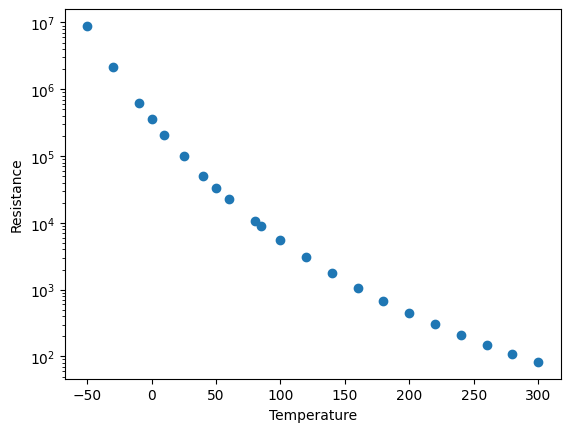

In [32]:
datasheetTemperatureArray_degC = np.array([-50, -30, -10, 0, 10, 25, 40, 50, 60, 80, 85, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])
datasheetResistanceArray_kOhms = [8887, 2156, 623.2, 354.6, 208.8, 100.0, 50.90, 33.45, 22.48, 10.80, 9.094, 5.569, 3.058, 1.770, 1.074, 0.6793, 0.4452, 0.3016, 0.2104, 0.1507, 0.1105, 0.08278]
datasheetResistanceArray_Ohms = np.array(datasheetResistanceArray_kOhms) * 1000
plotter.scatter(datasheetTemperatureArray_degC,datasheetResistanceArray_Ohms)
plotter.ylabel('Resistance')
plotter.yscale('log')
plotter.xlabel('Temperature')

## Calculate Thermistor Curve using Beta

In this next section, we use the easiest way to define a thermistor vs. temperature curve. This method only requires 3 pieces of data. The nominal temperature and nominal resistance define a specific point (essentially X, Y coordinates), and the beta value defines a "slope" even though it's not actually a true linear slope characteristic. 



In [33]:
thermistor_nominalTemp_degC = 25
thermistor_nominalResistance_Ohms = 100000
thermistor_beta = 4267

Next, we'll calculate the resistance for each temperature using these three parameters:

In [34]:
thermistor_temperature_complete_array = np.array(range(minRatedTemp_degC,maxRatedTemp_degC))
thermistor_resistance_beta_array = np.array(range(len(thermistor_temperature_complete_array)))

def celsiusToKelvin(temperature):
  return temperature + 273.15

def kelvinToCelsius(temperature):
  return temperature - 273.15

def convertTemperatureToResistance_Beta(temperature, nominalResistance_Ohms, nominalTemperature_degC, beta):
  resistance = nominalResistance_Ohms * math.exp(beta*((1/celsiusToKelvin(temperature))-(1/(celsiusToKelvin(nominalTemperature_degC)))))
  return resistance 

def convertResistanceToTemperature_Beta(resistance, nominalResistance_Ohms, nominalTemperature_degC, beta):
  temperature = beta / numpy.log
  return temperature 

def generateResistancefromTemperature_Beta(temperature_array,nominalResistance_Ohms, nominalTemperature_degC, beta):
  
for i in range(len(thermistor_temperature_complete_array)):
  thermistor_resistance_beta_array[i] = convertTemperatureToResistance_Beta(thermistor_temperature_complete_array[i], thermistor_nominalResistance_Ohms, thermistor_nominalTemp_degC, thermistor_beta)


Finally, lets make a quick plot of these values

Text(0.5, 0, 'Temperature')

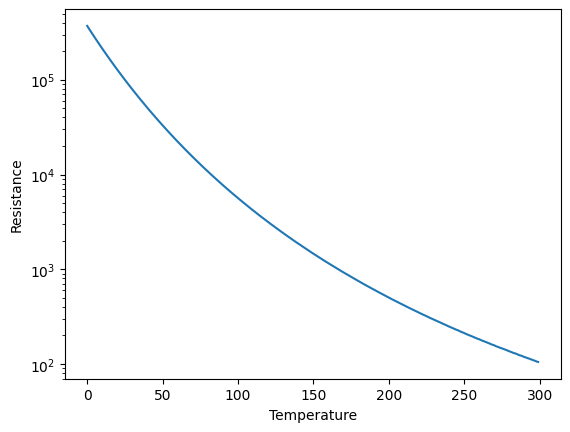

In [35]:
#@title
plotter.plot(thermistor_temperature_complete_array,thermistor_resistance_beta_array)
plotter.ylabel('Resistance')
plotter.yscale('log')
plotter.xlabel('Temperature')

## Calculate Thermistor Resistance using Steinhart–Hart Equation
Next, let's use a more accurate equation that more properly characterizes the temperature vs. resistance relationship of a thermistor. It needs 3 pairs of (temperature, resistance) points, which can be picked from anywhere. In this case, we will pick 25C, 100C, and 240C as those cover most of the common temperature ranges for thermistors and have values on the thermistor datasheet.

Text(0.5, 0, 'Temperature')

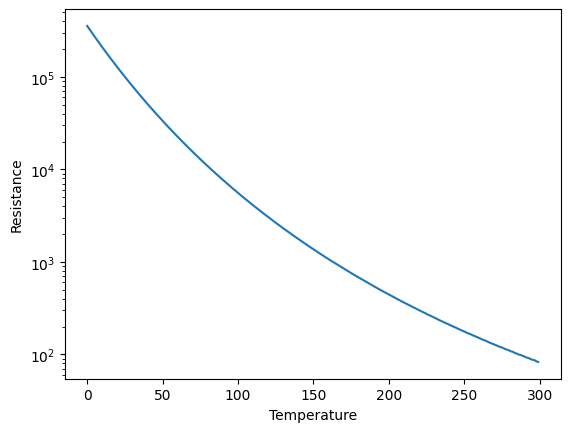

In [36]:
steinhart_hart_index_lower = [0, 2, 5]
steinhart_hart_index_upper = [5, 11, 18]

def calculateSteinhartHartCoefficients(steinhart_hart_index):
  steinhart_hart_temps = [0, 0, 0]
  steinhart_hart_resistance = [0,0,0]

  for i in range(3):
    steinhart_hart_temps[i] = datasheetTemperatureArray_degC[steinhart_hart_index[i]]
    steinhart_hart_resistance[i] = datasheetResistanceArray_Ohms[steinhart_hart_index[i]]

  L_1 = np.log(steinhart_hart_resistance[0])
  L_2 = np.log(steinhart_hart_resistance[1])
  L_3 = np.log(steinhart_hart_resistance[2])

  Y_1 = 1/celsiusToKelvin(steinhart_hart_temps[0])
  Y_2 = 1/celsiusToKelvin(steinhart_hart_temps[1])
  Y_3 = 1/celsiusToKelvin(steinhart_hart_temps[2])

  gamma_2 = (Y_2-Y_1)/(L_2-L_1)
  gamma_3 = (Y_3-Y_1)/(L_3-L_1)

  C = ((gamma_3-gamma_2)/(L_3-L_2))/(L_1+L_2+L_3)
  B = gamma_2 - C*(L_1**2 + L_1*L_2 + L_2**2)
  A = Y_1 - (B + L_1**2 * C) * L_1
  return A, B, C

def convertResistanceToTemperature_SH(resistance, A, B, C):
  temperature = 1/(A + B * np.log(resistance) + C * (np.log(resistance)**3))
  return temperature

def convertTemperatureToResistance_SH(temperature, A, B, C):
  x = 1/C * (A - 1/celsiusToKelvin(temperature))
  y = ((B/(3*C))**3 + (x**2)/4)**0.5
  resistance = np.exp((y-x/2)**(1/3)-(y+x/2)**(1/3))
  return resistance
  
[A,B,C] = calculateSteinhartHartCoefficients(steinhart_hart_index_upper)
[Al,Bl,Cl] = calculateSteinhartHartCoefficients(steinhart_hart_index_lower)

#temperature = kelvinToCelsius(convertResistanceToTemperature_SH(100000,A, B, C))
#print(temperature)
#resistance = convertTemperatureToResistance_SH(temperature, A, B, C)
#print(resistance)

thermistor_resistance_SH_array = np.array(range(len(thermistor_temperature_complete_array)))

for i in range(len(thermistor_temperature_complete_array)):
  if i < 5:
    thermistor_resistance_SH_array[i] = convertTemperatureToResistance_SH(thermistor_temperature_complete_array[i], Al, Bl, Cl)
  else:
    thermistor_resistance_SH_array[i] = convertTemperatureToResistance_SH(thermistor_temperature_complete_array[i], A, B, C)

plotter.plot(thermistor_temperature_complete_array,thermistor_resistance_SH_array)
plotter.ylabel('Resistance')
plotter.yscale('log')
plotter.xlabel('Temperature')

## Calculate Error in beta and Steinhart-Hart approximations

Now that we have this curve, let's compare these predicted values to the spec sheet:

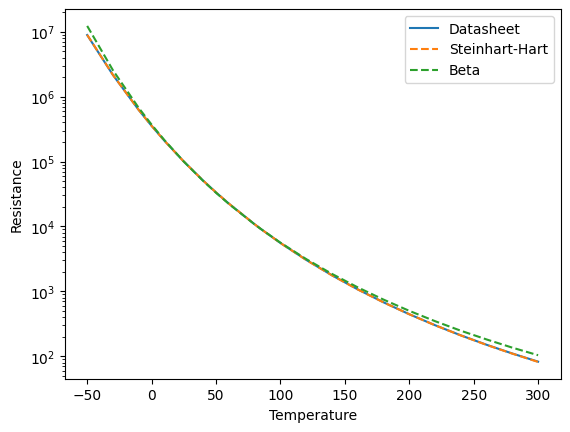

In [37]:
beta_resistance_datasheet = np.array(range(len(datasheetTemperatureArray_degC)))
SH_resistance_datasheet = np.array(range(len(datasheetTemperatureArray_degC)))

for i in range(len(datasheetTemperatureArray_degC)):
  beta_resistance_datasheet[i] = convertTemperatureToResistance_Beta(datasheetTemperatureArray_degC[i], thermistor_nominalResistance_Ohms, thermistor_nominalTemp_degC, thermistor_beta)
  SH_resistance_datasheet[i] = convertTemperatureToResistance_SH(datasheetTemperatureArray_degC[i], A, B, C)
  #print(datasheetTemperatureArray_degC[i], int(datasheetResistanceArray_Ohms[i]), int(thermistor_resistance_SH_array[i]), int(thermistor_resistance_beta_array[i]))

plotter.plot(datasheetTemperatureArray_degC,datasheetResistanceArray_Ohms, label="Datasheet")
plotter.plot(datasheetTemperatureArray_degC,SH_resistance_datasheet, label="Steinhart-Hart", linestyle='--')
plotter.plot(datasheetTemperatureArray_degC,beta_resistance_datasheet, label="Beta", linestyle='--')

plotter.ylabel('Resistance')
plotter.yscale('log')
plotter.xlabel('Temperature')
plotter.legend()

-50 -62768 -3387130
-30 -3551 -390360
-10 -375 -47732
0 -306 -15967
10 -167 -4635
25 1 0
40 2 518
50 -9 402
60 -12 246
80 1 36
85 0 1
100 1 -64
120 4 -90
140 2 -91
160 2 -81
180 1 -68
200 0 -56
220 0 -46
240 0 -37
260 0 -31
280 0 -25
300 0 -21


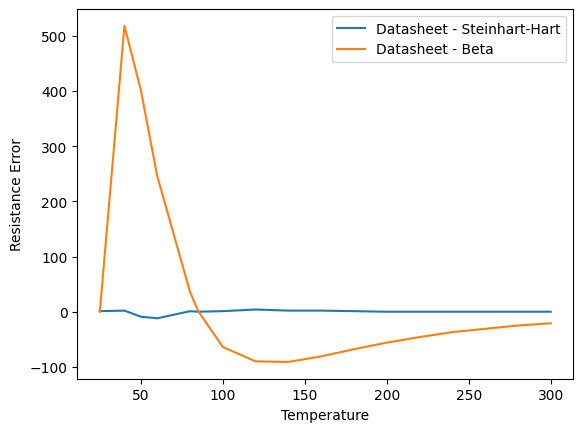

In [38]:
beta_resistance_error = np.array(range(len(datasheetTemperatureArray_degC)))
SH_resistance_error = np.array(range(len(datasheetTemperatureArray_degC)))

for i in range(len(datasheetTemperatureArray_degC)):
  beta_resistance_error[i] = datasheetResistanceArray_Ohms[i] - beta_resistance_datasheet[i]
  SH_resistance_error[i] = datasheetResistanceArray_Ohms[i] - SH_resistance_datasheet[i]
  print(datasheetTemperatureArray_degC[i], int(SH_resistance_error[i]), int(beta_resistance_error[i]))

start_index=5
plotter.plot(datasheetTemperatureArray_degC[start_index:],SH_resistance_error[start_index:], label="Datasheet - Steinhart-Hart")
plotter.plot(datasheetTemperatureArray_degC[start_index:],beta_resistance_error[start_index:], label="Datasheet - Beta")

plotter.ylabel('Resistance Error')
#plotter.yscale('log')
plotter.xlabel('Temperature')
plotter.legend()

-50 0 -38
-30 0 -18
-10 0 -7
0 0 -4
10 0 -2
25 0 0
40 0 1
50 0 1
60 0 1
80 0 0
85 0 0
100 0 -1
120 0 -2
140 0 -5
160 0 -7
180 0 -10
200 0 -12
220 0 -15
240 0 -17
260 0 -20
280 0 -23
300 0 -25


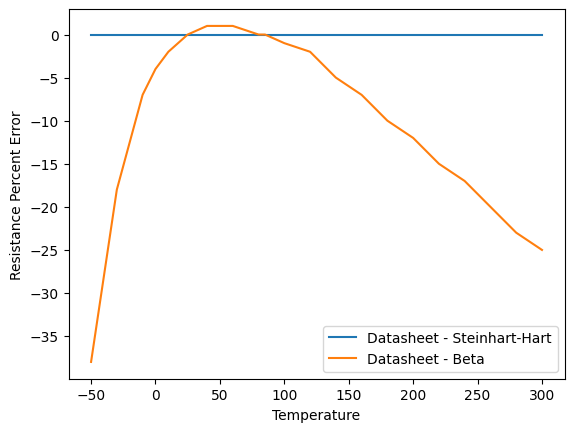

In [39]:
beta_resistance_percent_error = np.array(range(len(datasheetTemperatureArray_degC)))
SH_resistance_percent_error = np.array(range(len(datasheetTemperatureArray_degC)))

for i in range(len(datasheetTemperatureArray_degC)):
  beta_resistance_percent_error[i] = (datasheetResistanceArray_Ohms[i] - beta_resistance_datasheet[i])/datasheetResistanceArray_Ohms[i]*100
  SH_resistance_percent_error[i] = (datasheetResistanceArray_Ohms[i] - SH_resistance_datasheet[i])/datasheetResistanceArray_Ohms[i]*100
  print(datasheetTemperatureArray_degC[i], SH_resistance_percent_error[i], beta_resistance_percent_error[i])

start_index=0
plotter.plot(datasheetTemperatureArray_degC[start_index:],SH_resistance_percent_error[start_index:], label="Datasheet - Steinhart-Hart")
plotter.plot(datasheetTemperatureArray_degC[start_index:],beta_resistance_percent_error[start_index:], label="Datasheet - Beta")

plotter.ylabel('Resistance Percent Error')
#plotter.yscale('log')
plotter.xlabel('Temperature')
plotter.legend()

Turns out this doesn't help us much, since we don't care really about the resistance, but the actual temperature error! To do that, we'll need to create a "Resistance to Temperature" function, which will be the inverse of the earlier function: